# Top-down vs. bottom-up

Suppose we want to compute $3 \times 7 + 2 \times 9$.

*Operator precedence*&mdash;also called &ldquo;order of operations&rdquo;&mdash;is a matter of accepted notational convention. (We could agree on a different convention, in which case we&rsquo;d have to put parentheses in different places to express the same things.) It determines the meaning of an expression. In this example, the expression is a sum of products.

But operator precedence does not always determine *evaluation order*. In this example, we can do the multiplications in either order, but they both must be computed before the addition, because their results are what get added.

This expression tree shows the relationship between the **subproblems**:

In [1]:
from graphviz import Digraph

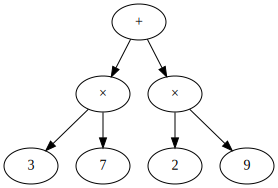

In [2]:
# Draw the tree.
tree = Digraph()
tree.node('left-times', label='\N{MULTIPLICATION SIGN}')
tree.node('right-times', label='\N{MULTIPLICATION SIGN}')
tree.edge('+', 'left-times')
tree.edge('left-times', '3')
tree.edge('left-times', '7')
tree.edge('+', 'right-times')
tree.edge('right-times', '2')
tree.edge('right-times', '9')
tree

*We can evaluate this expression **top-down***, which is naturally recursive. When we try to compute the sum, we notice that the product $3 \times 7$ must first be computed, so do that. For this, we must first know the values of $3$ and $7$, but they&rsquo;re literals, so we already do. Having now *returned* to our effort to compute the sum, we notice that the product $2 \times 9$ must first be computed, so do that. For this, we must know the values of $2$ and $9$, but they&rsquo;re literals, so we do. (Or we could have gone right to left and computed $2 \times 9$ before $3 \times 7$.) Then the sum can be computed.

*Or we can evaluate it **bottom-up***, which is naturally iterative. Notice that the solutions to all subproblems of $3 \times 7$&mdash;the literals $3$ and $7$&mdash;are known, so compute $3 \times 7$. Notice that the solutions to all subproblems of $2 \times 9$&mdash;the literals $2$ and $9$&mdash;are known, so compute $2 \times 9$. (Or we could have gone right to left and computed $2 \times 9$ before $3 \times 7$.) Notice, now, that the solutions to all subproblems of the whole sum are known, so compute it.

Mergesort likewise consists of smaller subproblems whose solutions are needed by bigger subproblems.  You&rsquo;ve implemented **top-down mergesort**, in `recursion.merge_sort`.

Can you implement **bottom-up mergesort**?

---

**Note:** Mergesort doesn&rsquo;t have *overlapping* subproblems, but many other important problems do, and the subject of overlapping subproblems is examined and visualized below.

## General example of a simple case of overlapping subproblems

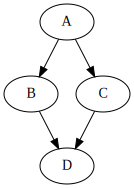

In [3]:
dag = Digraph()
dag.edge('A', 'B')
dag.edge('A', 'C')
dag.edge('B', 'D')
dag.edge('C', 'D')
dag

## Fibonacci

In [4]:
from fibonacci import fibonacci

In [5]:
fibonacci(10)

55

In [6]:
def drawfibn(n):
    fib = Digraph()
    for x in range(n + 1):
        if x == 0:
            fib.node('0')
        elif x ==1:
            fib.node('1')
        else: 
            fib.edge(str(x),str(x-2))
            fib.edge(str(x),str(x-1))
    return fib

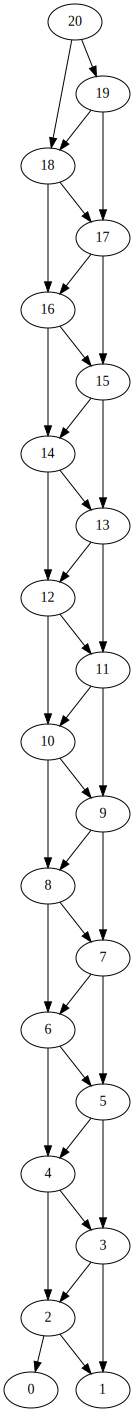

In [7]:
drawfibn(20)

**Note:** The function `fibonacci_better` has been moved to `fibonacci.py`.

In [8]:
# help(dict)

## Mergesort

In [9]:
import recursion

### Examining when and how often unequal-length lists are merged

In [10]:
def _format_count(count):
    return f'{count} element' if count == 1 else f'{count} elements'

def printing_merge(left, right):
    # print(f'Merging {left!r} with {right!r}.')
    if len(left) != len(right):
        left_format = _format_count(len(left))
        right_format = _format_count(len(right))
        print(f'Merging {left_format} with {right_format}.')
    return recursion.merge_two(left, right)

def mergesort_bottomup(values):
    return recursion.merge_sort_bottom_up_stable(values, merge=printing_merge)

In [11]:
mergesort_bottomup([30, 20, 10])

Merging 2 elements with 1 element.


[10, 20, 30]

In [12]:
mergesort_bottomup([7, 6, 5, 4, 3, 2, 1])

Merging 2 elements with 1 element.
Merging 4 elements with 3 elements.


[1, 2, 3, 4, 5, 6, 7]

In [13]:
result = mergesort_bottomup(range(5000))

Merging 128 elements with 8 elements.
Merging 256 elements with 136 elements.
Merging 512 elements with 392 elements.
Merging 4096 elements with 904 elements.


In [14]:
# result = mergesort_bottomup(range(10_000_000))

In [15]:
# result = recursion.merge_sort(range(10_000_000))

### Drawing the tree of mergesort subproblems

Dependency injection is very powerful, and except for trivial inputs, every node in the tree of subproblems corresponds to at least one of:

- an argument to a two-way merge (if it is not the root)
- a return value of a two-way merge (if it is not a leaf)

So it is temping to try visualizing the tree of subproblems in an *arbitrary* mergesort routine (that takes a two-way merge function), by giving a two-way merge function that both merges add adds vertices and edges to a drawing:

In [16]:
def draw_mergesort_subproblems_attempt_1(values, *,
                                         sort=recursion.merge_sort,
                                         merge=recursion.merge_two):
    """
    Draw a graph of mergesort subproblems. Create nodes leaf-to-root.
    
    Leaves show base cases. Internal nodes show return values from merges.
    """
    vertices = {}  # Prevents vertices (which are lists) from being collected.
    graph = Digraph()
    
    def register_vertex(node_object):
        """Add a vertex if not already added. Return the vertex name."""
        if id(node_object) not in vertices:
            vertices[id(node_object)] = node_object
            graph.node(str(id(node_object)), label=repr(node_object))
        return str(id(node_object))
    
    def instrumented_merge(left, right):
        print(f'Merging {left!r} with {right!r}.')  # For debugging.
        parent = merge(left, right)
        left_name = register_vertex(left)
        right_name = register_vertex(right)
        parent_name = register_vertex(parent)
        graph.edge(parent_name, left_name)
        graph.edge(parent_name, right_name)
        return parent
    
    sort(values, merge=instrumented_merge)
    return graph

But this is not quite right:

Merging ['B'] with ['C'].
Merging ['A'] with ['B', 'C'].


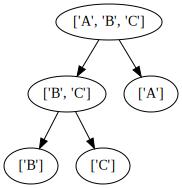

In [17]:
draw_mergesort_subproblems_attempt_1(['A', 'B', 'C'])

There are two problems:

1. Since we want to see the relationship between the subproblems, and it's more important for that to be clear than for us to see solutions, it would be better to show values before and after they are *split* (reading down the tree), rather than before and after they are *merged* (reading up the tree).

2. The order is not quite right. When $A$ is merged with $BC$, $A$ is on the left and $BC$ is on the right, but they are drawn in the other order. **Why?**

<details>
<summary><strong>Click to expand/collapse the answer to the question of why the tree is drawn out of order</strong></summary>
The ordering problem in the drawn graph, shown above, is that $ABC$ is made by merging $A$ with $BC$, and $BC$ is formed by merging $B$ with $C$, but leaves are not created until they participate in a merge, so $B$ and $C$ are created to form $BC$, and it is only after $B$ and $C$ are created that $A$ is created to form $ABC$. This is even though $A$ is on the left when it merges with $BC$ to produce $ABC$. Since $B$ and $C$ are created before $A$, Graphviz draws $BC$, which has $B$ and $C$ as its children, to the left of $A$. But we want $A$ to be drawn to the left of $BC$.
</details>

So it is best to implement the drawing function in another way.

Write a `merge_sort_instrumented` function in `recursion.py` that works like `merge_sort` but takes required keyword-only `observe_node` and `observe_edge` arguments. Put it immediately after the `merge_sort` function. Like `merge_sort`, it will have a recursive helper function that actually does the mergesorting.

1. Each call to the helper function will immediately call `observe_node` with its argument that corresponds to `values` in `merge_sort`. You may want to call this argument `node`.

2. When the helper function splits a list $AB$ (of any length) into $A$ and $B$, it will call `observe_edge` twice, one for the edge from $AB$ to $A$, and one for the edge from $AB$ to $B$, in that order.

3. For each subproblem (node/vertex), call `observe_node` exactly once.

4. For each subproblem relationship (edge), call `observe_edge` exactly once, *and ensure `observe_node` has always been called for both endpoints.*

To satisfy 3 and 4 above, it can be very useful to have the helper function accept more than one argument. Think about how that may help. If you take that approach, what should the other argument be? Is there a case where that other argument has to be treated specially? (That is not the only possible implementation approach, but it does make things quite a bit easier!)

After implementing `recursion.merge_sort_instrumented`, write a function below this cell called `draw_mergesort_subproblems` that uses `merge_sort_instrumented`&mdash;or any other function that notifies observers in the same way, if passed as an optional keyword-only argument. (See the signature below.) Try it on the following inputs:

- `['A', 'B', 'C']` (and compare to the above)
- `[]`
- `[1]`
- `[2, 1]`
- `[30, 20, 10]`
- `[7, 6, 5, 4, 3, 2, 1]`
- `[5660, -6307, 5315, 389, 3446, 2673, 1555, -7225, 1597, -7129]`
- `['foo', 'bar', 'baz', 'quux', 'foobar', 'ham', 'spam', 'eggs']`
- Anything else you feel like trying it on!

**Note:** Remembering that nodes are always observed before edges that connect them can help write simpler logic than was possible in the first attempt shown above.

In [18]:
def draw_mergesort_subproblems(values, *,
                               sort=recursion.merge_sort_instrumented,
                               merge=recursion.merge_two):
    """
    Draw a graph of mergesort subproblems. Create nodes root to leaf.
    
    A parent node is a list before splitting. Its left and right children are
    the left and right sides produced by the split, respectively.
    
    Leaves are base cases. The root is the original top-level input list.
    """
    vertices = {}  # Keeps vertices (which are lists) from being collected.
    graph = Digraph()
    
    def observe_node(values):
        vertices[id(values)] = values  # Keep the vertex from being collected.
        graph.node(str(id(values)), label=repr(values))
    
    def observe_edge(parent, child):
        graph.edge(str(id(parent)), str(id(child)))
    
    sort(values, merge=merge,
         observe_node=observe_node, observe_edge=observe_edge)
    
    return graph

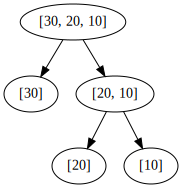

In [19]:
draw_mergesort_subproblems([30, 20, 10])

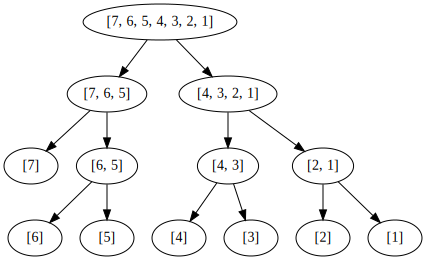

In [20]:
draw_mergesort_subproblems([7, 6, 5, 4, 3, 2, 1])

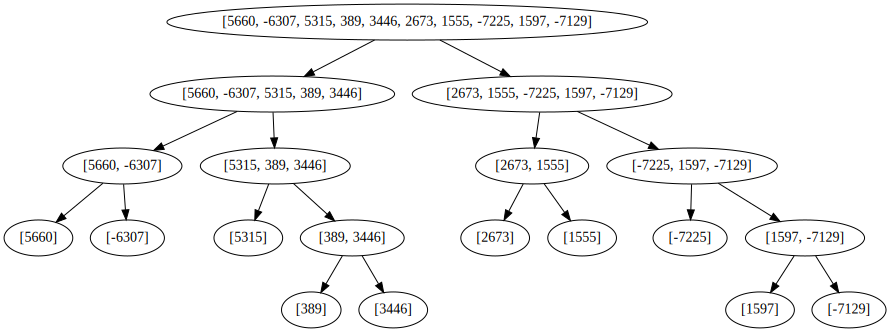

In [21]:
draw_mergesort_subproblems([5660, -6307, 5315, 389, 3446, 2673, 1555, -7225, 1597, -7129])

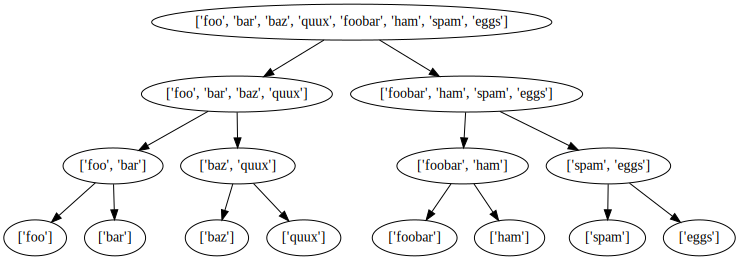

In [22]:
draw_mergesort_subproblems(['foo', 'bar', 'baz', 'quux', 'foobar', 'ham', 'spam', 'eggs'])